# Load all packages

In [33]:
## general
import numpy as np
import datetime
from sklearn.externals import joblib
import copy
import cf_units
import xarray as xr
import os
import sys
from tqdm import tqdm_notebook as tqdm
import datetime as dt


## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit, fmin
from sklearn.preprocessing import StandardScaler
from pygam import LinearGAM, s, te, f

# statistics which aren't all that nice in python
import rpy2.robjects as robjects

## my stuff
sys.path.insert(1,'/home/snath/polybox/LAMACLIMA/')
from tools.loading import load_data_single_mod, load_data_single_mod_rh
from tools.processing import AR1_predict, compute_llh_cv,gaspari_cohn
from tools.plotting import TaylorDiagram
from tools.GBR_fit import get_data_train_gbr

## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs

##for parallelisation
from sklearn.externals.joblib import Parallel, delayed
from scipy.interpolate import griddata

## customised tools
import block_cv
import load_data


# Load data

In [34]:
## Get the Aff, Def datasets for ESMs
data={}
data_lc={}

for model in ['CESM2']:
    
    print('Loading data for: ', model)
    data=load_data.load_data_tas(data,model)
    data_lc=load_data.load_data_lc(data_lc,model)
    idx_l, _, _, lon_pc, lat_pc = load_data.load_meta_data()
    
    
    

Loading data for:  CESM2


/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: Mean of empty slice


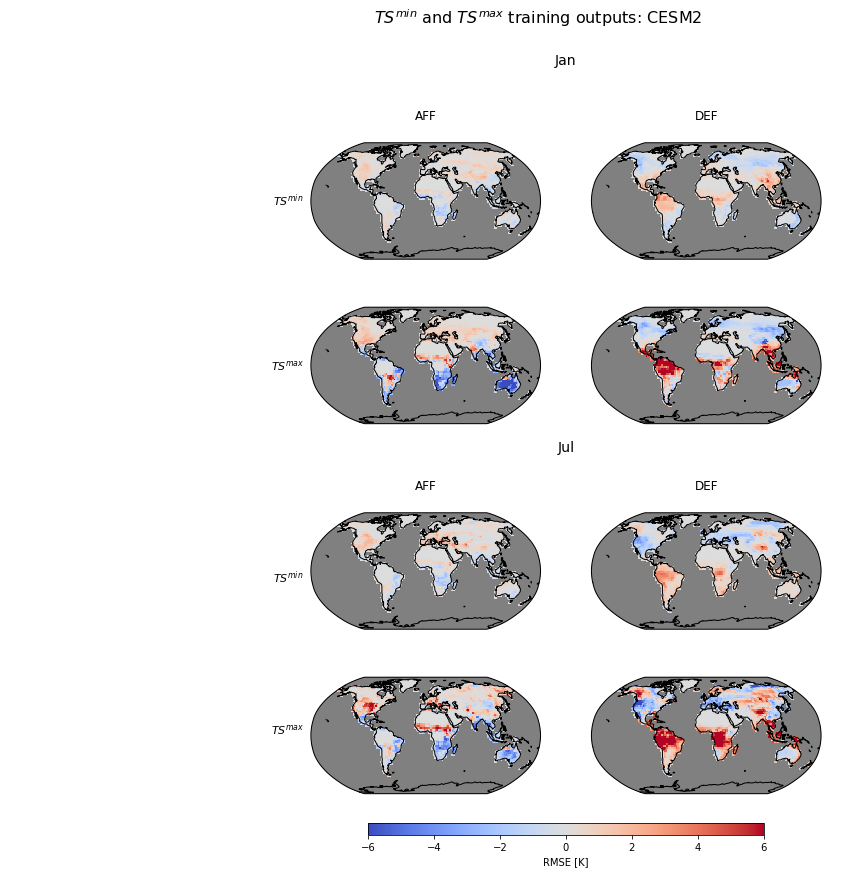

In [47]:
import matplotlib.colors as mcolors

model = 'CESM2'

n_col = 2
n_row = 2

fs_title=16

fig=plt.figure(figsize=(15, 15))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*5+10, n_col*10+10, wspace=0.2, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


axtitle=plt.subplot(grid[0,8:])
plt.title(r'$TS^{min}$ and $TS^{max}$ training outputs: CESM2',y=0.72,fontsize=16)
plt.axis('off')

colormap=plt.get_cmap('coolwarm')
colormap.set_bad(color = 'grey')


for i_mon in [0,6]:
    
    i_y=1
    for i_lab in range(2):
       
        if i_mon==0:
            i=2
        elif i_mon==6:
            i=11
        
        for var in ['ts_mn','ts_mx']:
            

            if i_mon==6 and var=='ts_mn' and i_lab==0:
                axcbar=plt.subplot(grid[18:,10:36]) 
                cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=35)
                cbar.ax.set_xlabel('RMSE [K]')
                plt.axis('off')
            
            if i_lab in [0,1]:
                X = np.hstack(([block_cv.create_prediction_set(data[model][var],data_lc[model][key],key,i_lab,i_mon)for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))

                y=lclm_gam[model]['%s_local'%var][i_mon].predict(X)
                y[np.abs(X[:,-1])<=0.01]=np.nan
                
                y_ma = np.zeros(idx_l.shape)
                y_ma = ma.masked_array(y_ma, mask=idx_l==False)

                y_ma[idx_l]=np.nanmean(data[model][var][i_lab].reshape(-1,12,idx_l.sum())[:,i_mon,:],axis = 0)
            
            if i_lab in [0,1]:
                ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))

                ax.coastlines()
                mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('coolwarm'),transform=ccrs.PlateCarree(),rasterized=True,vmin = -6, vmax = 6)
                
                if var=='ts_mn':
                    if i_lab==0:
                        ax.set_title('AFF\n',y=1.02,fontsize=12)
                    elif i_lab==1:
                        ax.set_title('DEF\n',y=1.02,fontsize=12)
            
            
            i+=4
        i_y+=1
        
            

axtitle=plt.subplot(grid[1,10:])
plt.title(r'Jan',y=0.72,fontsize=14)
plt.axis('off')

axtitle=plt.subplot(grid[10,10:])
plt.title(r'Jul',y=0.22,fontsize=14)
plt.axis('off')

axtitle=plt.subplot(grid[4,0])
plt.title(r'$TS^{min}$',y=0.22,fontsize=11,x=12)

plt.axis('off')

axtitle=plt.subplot(grid[8,0])
plt.title(r'$TS^{max}$',y=0.22,fontsize=11,x=12)

plt.axis('off')

axtitle=plt.subplot(grid[13,0])
plt.title(r'$TS^{min}$',y=0.02,fontsize=11,x=12)

plt.axis('off')

axtitle=plt.subplot(grid[17,0])
plt.title(r'$TS^{max}$'+'\n' ,y=0.02,fontsize=11,x=12)

plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/training_mn_mx.pdf')


# Load trained LCLM models and their CV results

In [5]:
## get ts_mean CV results
import joblib
from sklearn.externals import joblib as skjob
dir_data='/net/so4/landclim/snath/data/LCLM/'

lclm_gam={}
lam_sel={}
n_splines_sel={}

labels_final={}

lambdas=[0.001,0.01,0.1,1]
n_splines=[5,7,8,9]

for model in ['CESM2']:
    
    lam_sel[model]={}
    n_splines_sel[model]={}

    dir_in_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
    
    labels_final[model] = joblib.load(dir_data+'ts_'+model+'_idealised_g025/labels_final.pkl')
    scores_lclm_ts=skjob.load(dir_in_data_mod+model+'_FRST_CROP_GAM_CV_results.pkl')
    lclm_gam[model]=skjob.load(dir_in_data_mod+model+'_FRST_CROP_GAM_final.pkl')
    
    for var in ['ts_mn_local','ts_mx_local']:

        lam_sel[model][var]={}
        n_splines_sel[model][var]={}



        for i_mon in tqdm(range(12)):
            
            
            lam_sel[model][var][i_mon],n_splines_sel[model][var][i_mon]=block_cv.GridSearch_sel(scores_lclm_ts[var][i_mon],np.unique(labels_final[model]),lambdas,n_splines)

                
            


## Calibration

/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


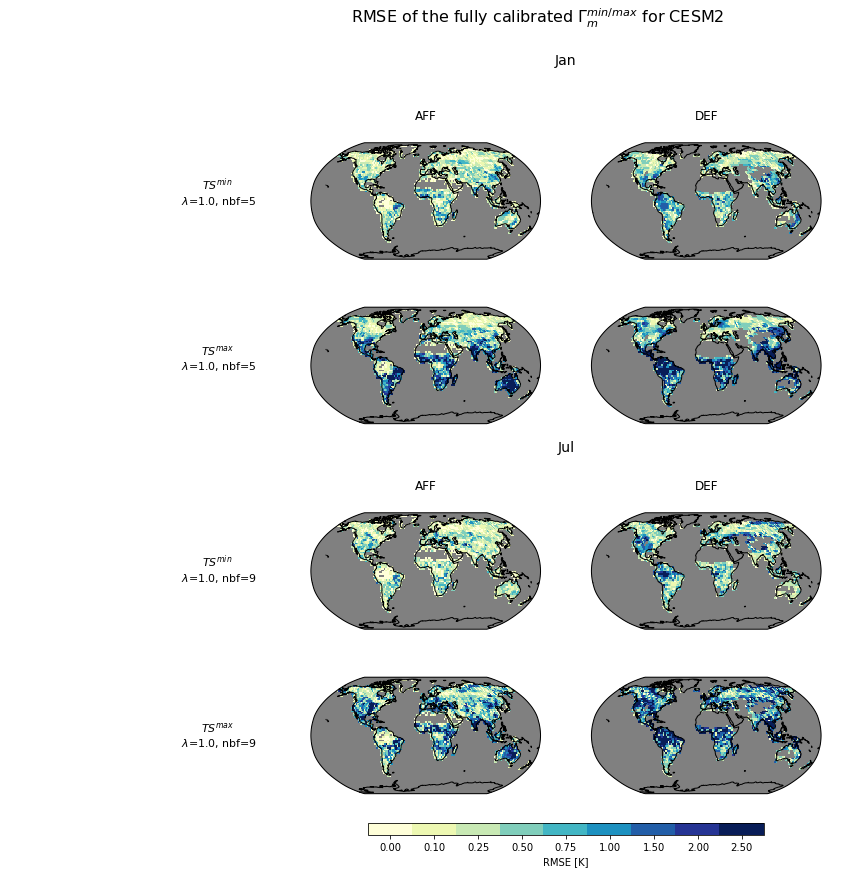

In [48]:
import matplotlib.colors as mcolors

dir_data='/net/so4/landclim/snath/data/LCLM/'
model = 'CESM2'

n_col = 2
n_row = 2

fs_title=16

fig=plt.figure(figsize=(15,15))
plt.rcParams.update({'font.size': 10})
plt.rcParams.update({'mathtext.default':'regular'}) 
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*5+10, n_col*10+10, wspace=0.2, hspace=0.2) # create a grid for the subplots #0.12

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)


axtitle=plt.subplot(grid[0,8:])
plt.title(r'RMSE of the fully calibrated $\Gamma^{min/max}_{m}$ for CESM2',y=0.72,fontsize=16)
plt.axis('off')

colormap=plt.get_cmap('YlGnBu')
colormap.set_bad(color = 'grey')

bounds = [-0.05,0.05,0.15,0.35,0.65,0.85,1.15,1.85,2.15,2.85]
norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)

for i_mon in [0,6]:
    
    i_y=1
    for i_lab in range(2):
       
        if i_mon==0:
            i=2
        elif i_mon==6:
            i=11
        
        for var in ['ts_mn','ts_mx']:
            

            if i_mon==6 and var=='ts_mn' and i_lab==0:
                axcbar=plt.subplot(grid[18:,10:36]) 
                cbar=plt.colorbar(mesh_1,orientation='horizontal',aspect=35,ticks=[0,0.1,0.25,0.5,0.75,1,1.5,2,2.5])
                cbar.ax.set_xlabel('RMSE [K]')
                plt.axis('off')
            
            if i_lab in [0,1]:
                X = np.hstack(([block_cv.create_prediction_set(data[model][var],data_lc[model][key],key,i_lab,i_mon)for key in data_lc[model].keys() if key in ['lon','lat','orog','treeFrac']]))

                y=lclm_gam[model]['%s_local'%var][i_mon].predict(X)
                y[np.abs(X[:,-1])<=0.01]=np.nan
                
                y_ma = np.zeros(idx_l.shape)
                y_ma = ma.masked_array(y_ma, mask=idx_l==False)

                y_ma[idx_l]=np.array([[block_cv.calculate_rmse_gp(y[i_grid],
                                                        np.nanmean(data[model][var][i_lab].reshape(-1,12,idx_l.sum())[:,i_mon,i_grid]))\
                                       for i_grid in np.arange(idx_l.sum())]]).flatten()
            
            if i_lab in [0,1]:
                ax = plt.subplot(grid[i+1:i+4,i_y*10:i_y*10+10], projection=ccrs.Robinson(central_longitude=0))

                ax.coastlines()
                mesh_1=ax.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=plt.get_cmap('YlGnBu'),transform=ccrs.PlateCarree(),rasterized=True,norm=norm)
                
                if var=='ts_mn':
                    if i_lab==0:
                        ax.set_title('AFF\n',y=1.02,fontsize=12)
                    elif i_lab==1:
                        ax.set_title('DEF\n',y=1.02,fontsize=12)
           
            i+=4
        i_y+=1
        
            

axtitle=plt.subplot(grid[1,10:])
plt.title(r'Jan',y=0.72,fontsize=14)
plt.axis('off')

axtitle=plt.subplot(grid[10,10:])
plt.title(r'Jul',y=0.22,fontsize=14)
plt.axis('off')

axtitle=plt.subplot(grid[4,0])
plt.title(r'$TS^{min}$'+'\n' +r' $\lambda$=%.1f, nbf=%i'%(lam_sel[model]['ts_mn_local'][0],
n_splines_sel[model]['ts_mn_local'][0]),y=0.22,fontsize=11,x=9)

plt.axis('off')

axtitle=plt.subplot(grid[8,0])
plt.title(r'$TS^{max}$'+'\n' +r' $\lambda$=%.1f, nbf=%i'%(lam_sel[model]['ts_mx_local'][0],
n_splines_sel[model]['ts_mx_local'][0]),y=0.22,fontsize=11,x=9)

plt.axis('off')

axtitle=plt.subplot(grid[13,0])
plt.title(r'$TS^{min}$'+'\n' +r' $\lambda$=%.1f, nbf=%i'%(lam_sel[model]['ts_mn_local'][6],
n_splines_sel[model]['ts_mn_local'][6]),y=0.02,fontsize=11,x=9)

plt.axis('off')

axtitle=plt.subplot(grid[17,0])
plt.title(r'$TS^{max}$'+'\n' +r' $\lambda$=%.1f, nbf=%i'%(lam_sel[model]['ts_mx_local'][6],
n_splines_sel[model]['ts_mx_local'][6]),y=0.02,fontsize=11,x=9)

plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/final_gam_per_mn_mx.pdf')


## Climate evaluation

In [39]:
actual_error={}

for model in ['CESM2']:
    
        dir_in_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
            
        actual_error[model] = skjob.load(dir_in_data_mod+'model_cv_eval_clim.pkl')


/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in greater
/home/snath/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: inval

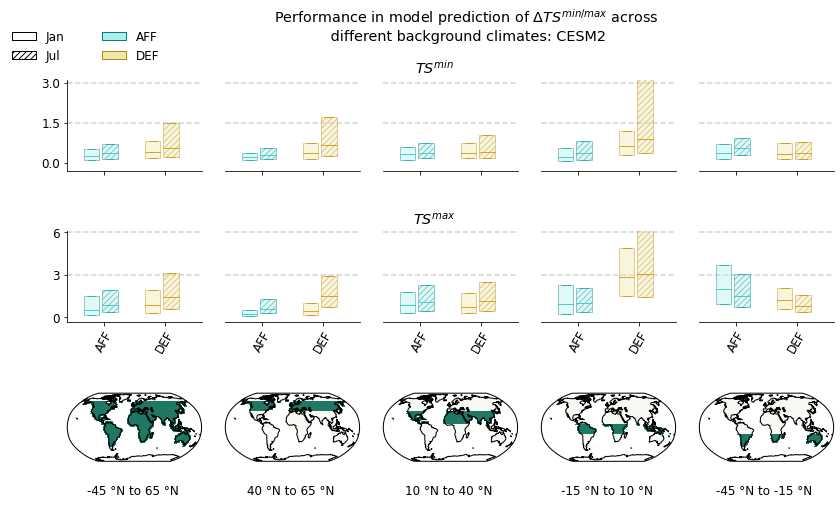

In [49]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import skewnorm
import pandas as pd
from matplotlib.patches import Patch

regions=['Global','North\n America','South\n America','Africa\n','Eurasia\n','Australia\n','CGI','Tibet\n','South-East\n Asia']
score='rmse'
model = 'CESM2'

colors=plt.cm.plasma(np.linspace(0, 1, 8))
bp={}

white = np.array([248/256, 250/256, 245/256, 1])
blue = np.array([30/256, 120/256, 100/256, 1])

colors = np.vstack((white,blue))
mymap = LinearSegmentedColormap.from_list('my_colormap', colors, N=2)

fs_title=18
n_row = 2
n_col=5

plt.figure(figsize=(16, 10))

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*6+6, n_col*5+3, wspace=-0.2, hspace=0) # create a grid for the subplots #0.12

axtext=plt.subplot(grid[:1,5:-6])
plt.title(r'Performance in model prediction of $\Delta TS^{min/max}$ across'+'\n different background climates: CESM2',y=0.1)
plt.axis('off')

axtext=plt.subplot(grid[1:2,2:-5])
plt.title(r'$TS^{min}$',y=0.02)
plt.axis('off')

axtext=plt.subplot(grid[6:7,2:-5])
plt.title(r'$TS^{max}$',y=0.02)
plt.axis('off')
    

i_x=2
for var in ['ts_mn_local','ts_mx_local']:    

    bp[var]={}
   
    i_y=1
    bp[var][model]={}

    y_ma = np.full([2,2,idx_l.shape[0],idx_l.shape[1]],np.nan)                
    y_ma[:,:,idx_l]=actual_error[model][score][var][:,[0,6],:]

    for i_reg,lat_vals in enumerate(zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1])):


        start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
        stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

        n_gp=(stop_lat-start_lat)*(len(lon_pc)-1)

        bp[var][model][i_reg]={'Aff':[],'Def':[]}


        ax=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4])



        arr_aff=y_ma[0,:,start_lat:stop_lat,:]
        arr_aff=arr_aff[~np.isnan(arr_aff)].reshape(2,-1)
        bp[var][model][i_reg]['Aff'].append(ax.boxplot(arr_aff.T,positions=[0.3,0.6],whis=[25,75],showfliers=False,showcaps=True,patch_artist=True,widths = 0.25,))
        #print(arr_aff)

        arr_def=y_ma[1,:,start_lat:stop_lat,:].reshape(2,-1)
        arr_def[:,np.argwhere(np.logical_and(arr_def[0,:]>15,
                                                  arr_def[1,:]>15))]=np.nan
        arr_def=arr_def[:,np.argwhere(np.logical_and(~np.isnan(arr_def[0,:]),
                                                  ~np.isnan(arr_def[1,:])))].reshape(2,-1)


        bp[var][model][i_reg]['Def'].append(ax.boxplot(arr_def.T,positions=[1.3,1.6],whis=[25,75],showfliers=False,showcaps=True,patch_artist=True,widths = 0.25,))


        for box_aff,box_def in zip(bp[var][model][i_reg]['Aff'],bp[var][model][i_reg]['Def']):
            plt.setp(box_aff['boxes'], color='teal')


            for i_patch,patch in enumerate(box_aff['boxes']):

                if i_patch==1:
                    patch.set(hatch='////',color='teal')

                patch.set(facecolor='paleturquoise',alpha=0.4)

            plt.setp(box_aff['medians'],color='mediumturquoise',linewidth=1)
            plt.setp(box_aff['whiskers'],color='mediumturquoise',linewidth=1)
            plt.setp(box_aff['caps'],color='mediumturquoise',linewidth=1)

            plt.setp(box_def['boxes'], color='darkgoldenrod')

            for i_patch,patch in enumerate(box_def['boxes']):

                if i_patch==1:
                    patch.set(hatch='////',color='darkgoldenrod')

                patch.set(facecolor='palegoldenrod',alpha=0.4)

            plt.setp(box_def['medians'],color='goldenrod',linewidth=1)
            plt.setp(box_def['whiskers'],color='goldenrod',linewidth=1)
            plt.setp(box_def['caps'],color='goldenrod',linewidth=1)

    
        plt.xlim(-0.1,2.1)
        plt.yticks([0,5,10,15])
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if np.logical_or(lat_vals[0]!=-45,lat_vals[1]!=65):
            ax.spines['left'].set_visible(False)
            ax.tick_params(labelleft=False)
            ax.tick_params(left=False)

        plt.xticks([0.5,1.5],labels=['',''],rotation=60)

        if var=='ts_mx_local':
            plt.ylim(-0.3,6.1)
            plt.yticks([0,3,6])
            plt.hlines(3,-0.1,2.1,linestyle='--',color='lightgrey')
            plt.hlines(6,-0.1,2.1,linestyle='--',color='lightgrey')
            plt.xticks([0.5,1.5],labels=['AFF','DEF'],rotation=60)

        elif var=='ts_mn_local':
            plt.ylim(-0.3,3.1)
            plt.yticks([0,1.5,3])
            plt.hlines(1.5,-0.1,2.1,linestyle='--',color='lightgrey')
            plt.hlines(3,-0.1,2.1,linestyle='--',color='lightgrey')



        i_y+=5

    i_x+=5

i_y=1

for lat_vals in zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1]):

    start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
    stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

    axreg=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4],projection=ccrs.Robinson(central_longitude=0))
    y_ma = np.zeros(idx_l.shape)
    y_ma[start_lat:stop_lat,:]=1
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)
    axreg.coastlines()
    mesh_1=axreg.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,vmin=0,vmax=1,transform=ccrs.PlateCarree(),rasterized=True)

    plt.title('%i °N to %i °N \n'%(lat_vals[0],lat_vals[1]),rotation=0,fontsize=12,y=-0.8)


    i_y+=5

                      

axlegend=plt.subplot(grid[:1,:1])
plt.legend([Patch(facecolor='white',edgecolor='black'),
       Patch(facecolor='white',edgecolor='black',hatch='////')],['Jan','Jul'],frameon=False,fontsize=12)
plt.axis('off')

axlegend=plt.subplot(grid[:1,3:4])
plt.legend([Patch(facecolor='paleturquoise',edgecolor='teal'),
       Patch(facecolor='palegoldenrod',edgecolor='darkgoldenrod')],['AFF','DEF'],frameon=False,fontsize=12)
plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/reg_extrap_obs_esm_mn_mx.pdf')


# Tree cover evaluation

In [41]:
treefrac_bins=[[-1,-0.8],[-0.8,-0.5],[-0.5,-0.3],[-0.3,-0.15],[-0.15,-0.01],
               [0.01,0.15],[0.15,0.3],[0.3,0.5],[0.5,0.8],[0.8,1]]
extrapolated_error={}


for model in ['CESM2']:
   

    dir_in_data_mod=dir_data+'tsmn_tsmx_'+model+'_idealised_g025/'
            
    extrapolated_error[model] = skjob.load(dir_in_data_mod+'model_cv_eval_treecov.pkl')

                                           

    


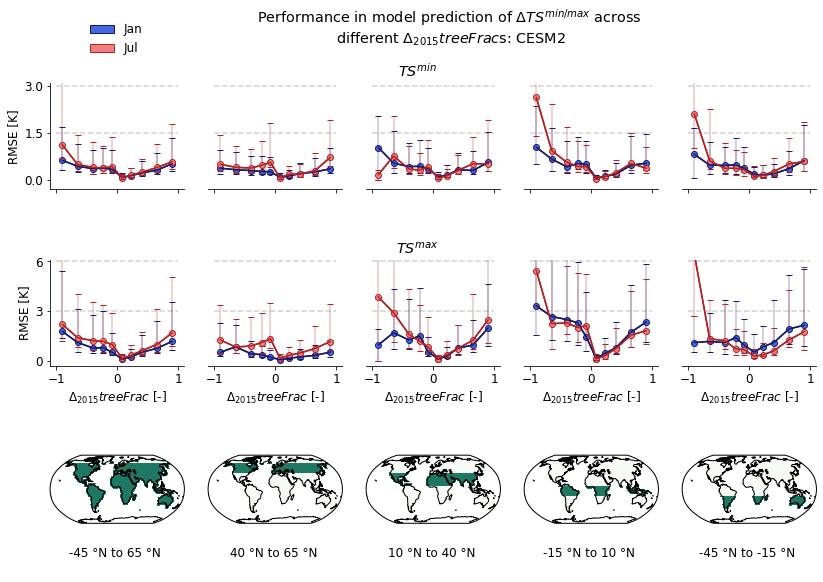

In [42]:
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import skewnorm
import pandas as pd
from matplotlib.lines import Line2D

model = 'CESM2'
score='rmse'
colors=plt.cm.Set1(np.linspace(0, 1, 9))
xticks=[-0.9,-0.65,-0.4,-0.225,-0.08,0.08,0.225,0.4,0.65,0.9]

regions=['Global','North\n America','South\n America','Africa\n','Eurasia\n','Australia\n','CGI','Tibet\n','South-East\n Asia']

score='rmse'
colors=plt.cm.plasma(np.linspace(0, 1, 8))


white = np.array([248/256, 250/256, 245/256, 1])
blue = np.array([30/256, 120/256, 100/256, 1])

colors = np.vstack((white,blue))
mymap = LinearSegmentedColormap.from_list('my_colormap', colors, N=2)

fs_title=18
n_row = 2
n_col=5

plt.figure(figsize=(16, 13))

plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'mathtext.default':'it'}) 


grid = plt.GridSpec(n_row*7+6, n_col*5+3, wspace=-0.2, hspace=0) # create a grid for the subplots #0.12

axtext=plt.subplot(grid[:1,5:-6])
plt.title(r'Performance in model prediction of $\Delta TS^{min/max}$ across'+'\n different $\Delta_{2015}treeFrac$s: CESM2',y=-0.05)
plt.axis('off')

axtext=plt.subplot(grid[1:2,2:-5])
plt.title(r'$TS^{min}$',y=0.02)
plt.axis('off')

axtext=plt.subplot(grid[6:7,2:-5])
plt.title(r'$TS^{max}$',y=0.02)
plt.axis('off')

i_x=2
    
for var in ['ts_mn_local','ts_mx_local']:

    i_y=1
    y_ma = np.full([10,2,idx_l.shape[0],idx_l.shape[1]],np.nan)                

    y_ma[:,:,idx_l]=extrapolated_error[model][var][:,[0,6],:].copy()

    #print(i_x)
    for lat_vals in zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1]):


        start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
        stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

        n_gp=(stop_lat-start_lat)*(len(lon_pc)-1)


        plot_extrapolated_error = np.nanquantile(y_ma[:,:,start_lat:stop_lat,:],0.5,axis=(2,3))

        plot_extrapolated_error_bounds = np.zeros([2,10,2])
        plot_extrapolated_error_bounds[0,:,:] = np.nanquantile(y_ma[:,:,start_lat:stop_lat,:],0.25,axis=(2,3))
        plot_extrapolated_error_bounds[1,:,:] = np.nanquantile(y_ma[:,:,start_lat:stop_lat,:],0.75,axis=(2,3))


        ax=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4])
        plt.ylim(-0.3,15.1)
        
        if var=='ts_mn_local':
            plt.ylim(-0.3,3.1)
            plt.yticks([0,1.5,3])
            plt.hlines(1.5,-1,1,linestyle='--',color='lightgrey')
            plt.hlines(3,-1,1,linestyle='--',color='lightgrey')

        elif var=='ts_mx_local':
            plt.ylim(-0.3,6.1)
            plt.yticks([0,3,6])
            plt.hlines(3,-1,1,linestyle='--',color='lightgrey')
            plt.hlines(6,-1,1,linestyle='--',color='lightgrey')

        plt.plot(xticks,plot_extrapolated_error[:,0],marker='o',markerfacecolor='royalblue',markeredgecolor='midnightblue',color='midnightblue',linestyle='-')
        plt.errorbar(xticks,plot_extrapolated_error[:,0],yerr=plot_extrapolated_error_bounds[:,:,0],color='midnightblue',ecolor='midnightblue',capsize=3,elinewidth=0.4)

        plt.plot(xticks,plot_extrapolated_error[:,1],marker='o',markerfacecolor='lightcoral',markeredgecolor='firebrick',color='firebrick',linestyle='-')
        plt.errorbar(xticks,plot_extrapolated_error[:,1],yerr=plot_extrapolated_error_bounds[:,:,1],color='firebrick',ecolor='firebrick',capsize=3,elinewidth=0.4)


        plt.xlim(-1.1,1.1)

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        if np.logical_or(lat_vals[0]!=-45,lat_vals[1]!=65):
            ax.spines['left'].set_visible(False)
            ax.tick_params(labelleft=False)
            ax.tick_params(left=False)

        ax.tick_params(labelbottom=False)
        if var=='ts_mx_local':
            ax.tick_params(labelbottom=True)
            plt.xlabel(r'$\Delta_{2015}treeFrac$ [-]')

        if np.logical_and(lat_vals[0]==-45,lat_vals[1]==65):    
            plt.ylabel('RMSE [K]')


        i_y+=5

    i_x+=5
        
i_y=1
for lat_vals in zip([-45,-15,10,40,-45][::-1],[-15,10,40,65,65][::-1]):

    start_lat=np.argwhere(lat_pc==lat_vals[0])[0][0]
    stop_lat=np.argwhere(lat_pc==lat_vals[1])[0][0]

    axreg=plt.subplot(grid[i_x:i_x+3,i_y:i_y+4],projection=ccrs.Robinson(central_longitude=0))
    y_ma = np.zeros(idx_l.shape)
    y_ma[start_lat:stop_lat,:]=1
    y_ma = ma.masked_array(y_ma, mask=idx_l==False)
    axreg.coastlines()
    mesh_1=axreg.pcolormesh(lon_pc, lat_pc, y_ma,  cmap=mymap,vmin=0,vmax=1,transform=ccrs.PlateCarree(),rasterized=True)

    plt.title('%i °N to %i °N \n'%(lat_vals[0],lat_vals[1]),rotation=0,fontsize=12,y=-0.8)


    i_y+=5

            
            
            

axlegend=plt.subplot(grid[:1,3:4])
plt.legend([Patch(facecolor='royalblue',edgecolor='midnightblue'),
       Patch(facecolor='lightcoral',edgecolor='firebrick')],['Jan','Jul'],frameon=False,fontsize=12)
plt.axis('off')

plt.savefig('/net/so4/landclim/snath/LCLM-mod_Pictures/reg_tree_extrap_obs_esm_mn_mx.pdf')
